# Prepare environment

In [ ]:
!pip install datasets langchain[llms]

In [ ]:
import datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.output_parsers import StructuredOutputParser, OutputFixingParser, ResponseSchema
from langchain.callbacks import get_openai_callback
import json
from datetime import datetime
import time
import pickle
from google.colab import files

In [ ]:
# Configure general variables
seed = 42
openai_org = "..."
openai_key = "..."

# Prepare datasets

In [ ]:
# Load the original training datasets
train = datasets.load_dataset("tum-nlp/IDMGSP", "train+gpt3", split="train")

# Randomly shuffle the dataset
train_shuffled = train.shuffle(seed=seed)

# Create a single training dataset with alternating examples from each source
train_real = train_shuffled.filter(lambda x: x["src"] == "real")
train_scigen = train_shuffled.filter(lambda x: x["src"] == "scigen")
train_galactica = train_shuffled.filter(lambda x: x["src"] == "galactica")
train_gpt2 = train_shuffled.filter(lambda x: x["src"] == "gpt2")
train_gpt3 = train_shuffled.filter(lambda x: x["src"] == "gpt3")
train_chatgpt = train_shuffled.filter(lambda x: x["src"] == "chatgpt")
data_train = datasets.interleave_datasets([train_real, train_scigen, train_galactica, train_gpt2, train_gpt3, train_chatgpt])

Generating train split:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

In [ ]:
# Load the original test datasets
test = datasets.load_dataset("tum-nlp/IDMGSP", "classifier_input", split="test")
ood_gpt3 = datasets.load_dataset("tum-nlp/IDMGSP", "ood_gpt3", split="test")
ood_real = datasets.load_dataset("tum-nlp/IDMGSP", "ood_real", split="test")
test_cc = datasets.load_dataset("tum-nlp/IDMGSP", "test-cc", split="test")
tecg = datasets.load_dataset("tum-nlp/IDMGSP", "tecg", split="test", verification_mode="no_checks")

# Randomly shuffle the datasets
test_shuffled = test.shuffle(seed=seed)
ood_gpt3_shuffled = ood_gpt3.shuffle(seed=seed)
ood_real_shuffled = ood_real.shuffle(seed=seed)
test_cc_shuffled = test_cc.shuffle(seed=seed)
tecg_shuffled = tecg.shuffle(seed=seed)

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4000 [00:00<?, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Create a single test dataset with alternating examples from each source
test_real = test_shuffled.filter(lambda x: x["src"] == "real")
test_scigen = test_shuffled.filter(lambda x: x["src"] == "scigen")
test_galactica = test_shuffled.filter(lambda x: x["src"] == "galactica")
test_gpt2 = test_shuffled.filter(lambda x: x["src"] == "gpt2")
test_gpt3 = ood_gpt3_shuffled.filter(lambda x: x["src"] == "gpt3")
test_chatgpt = test_shuffled.filter(lambda x: x["src"] == "chatgpt")
test_all = datasets.interleave_datasets([test_real, test_scigen, test_galactica, test_gpt2, test_gpt3, test_chatgpt])

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

# Define prompting functions

In [ ]:
# Define reusable prompt parts
# general_task = "Your task is to guess if a scientific paper was written by a human or by a machine language model."
general_task = "Your task is to guess if a scientific paper was written by a machine language model."
paper_introduction = "Here is a scientific paper with its abstract, introduction, and conclusion:"
question = "Was this scientific paper written by a human or by a machine language model? You must decide for either 'human' or 'machine'. It is not allowed to give 'unknown' as an answer."
# question = "Was this scientific paper written by a machine language model or by a human? You must decide for either 'machine' or 'human'. It is not allowed to give 'unknown' as an answer."
# question = "Was this scientific paper written by a machine language model?"
approach_cot = "Let's think step by step."
approach_indicators = "First, identify indications for a human author and indications for a machine author. Second, considering these indications, conclude whether the scientific paper was written by a human or machine."

# Define reusable response schemas for output formatting and parsing
schema_author = ResponseSchema(name="author", description="most likely author of the scientific paper (either 'human' or 'machine')")
# schema_author = ResponseSchema(name="author", description="most likely author of the scientific paper (either 'machine' or 'human')")
schema_explanation = ResponseSchema(name="explanation", description="elaborate explanation why the scientific paper was most likely written by the author stated above")
schema_human_indications = ResponseSchema(name="human_indications", description="concrete observations that indicate that the scientific paper was written by a human")
schema_machine_indications = ResponseSchema(name="machine_indications", description="concrete observations that indicate that the scientific paper was written by a machine")
schema_thoughts = ResponseSchema(name="thoughts", description="thoughts on approach and reasons")

# Define the prompt template for system messages
system_message_template = SystemMessagePromptTemplate(prompt=PromptTemplate(
    template="{general_task}",
    input_variables=[],
    partial_variables={
        "general_task": general_task
    }
))

# Define the prompt template for human messages with a scientific paper and the prompt question
human_message_template = HumanMessagePromptTemplate(prompt=PromptTemplate(
    template="{paper_introduction}\n\nAbstract:\n{abstract}\n\nIntroduction:\n{introduction}\n\nConclusion:\n{conclusion}\n\n{question} {approach}\n\n{format_instructions}",
    input_variables=["abstract", "introduction", "conclusion", "approach", "format_instructions"],
    partial_variables={
        "question": question,
        "paper_introduction": paper_introduction
    }
))

# Define the prompt template for AI answer messages guessing the author
ai_message_template = AIMessagePromptTemplate(prompt=PromptTemplate(
    template="```json\n{{\n\t\"author\": \"{author}\",\n\t\"explanation\": \"{explanation}\"\n}}\n```",
    input_variables=["author", "explanation"]
))
ai_message_template_author_only = AIMessagePromptTemplate(prompt=PromptTemplate(
    template="```json\n{{\n\t\"author\": \"{author}\"\n}}\n```",
    input_variables=["author"]
))


# Input-output (IO) prompting with explanation
def predict_author_IO(model, abstract, introduction, conclusion, few_shot=False, explain=True):
    # Define the output schema and parser (OutputFixingParser will try to fix the LLM output in case the StructuredOutputParser fails)
    output_parser = OutputFixingParser.from_llm(
        parser=StructuredOutputParser.from_response_schemas([schema_author, schema_explanation] if explain else [schema_author]),
        llm=model
    )

    # Assemble a list of chat messages
    messages = []
    messages.append(system_message_template.format())

    # If few-shot prompting is requested, add previous human and AI messages with example inputs and answers
    if few_shot:
        # Define the list of examples for few-shot prompting
        example_indices = [0, 1, 2, 3, 4, 5]
        authors = ["human" if src == "real" else "machine" for src in data_train.select(example_indices)["src"]]
        explanations = [
            "1. Clear and Detailed Structure: The paper has a clear structure, with each section having a specific purpose and its content contributing to the overall argument or discussion. The introduction also outlines the structure of the full paper, indicating what each section will cover, which is common in academic writing.\n2. Consistent and Relevant References: References ([1], [2], [3], [4], [5]) are mentioned consistently and relevantly, indicating the author's engagement with existing research. The numbers likely correspond to a list of references not included in this extract.\n3. Logical Argumentation: The arguments presented in the paper are logical and coherent, with each point leading naturally to the next. The author sets out clear research questions and gives detailed explanations, drawing on the principles of object-oriented programming.\n4. Specific and Contextually Appropriate Terminology: The paper uses specific terms appropriate to the field of computer science, such as \"data encapsulation\", \"inheritance\", \"class flattening\", and \"refactoring\". The definitions and explanations provided for these terms are correct and contextually appropriate.\n5. Future Work: The conclusion section includes plans for future work, a common aspect of human-written academic papers that seek to build upon initial findings or theories. The writer articulates their intention to empirically test the theoretical assumptions made in the paper.",
            "1. Lack of Coherence and Precision: While the paper does include technical language and appears to discuss topics related to computer science, the language is overly verbose and the ideas are not clearly connected. It frequently uses grandiose language (\"our new approach for virtual machines is the solution to all of these challenges\") without backing it up with detailed explanations or concrete examples.\n2. Vagueness in Methodology: The paper seems to jump between different topics (virtual machines, wide-area networks, the lookaside buffer, Internet QoS, etc.) without a clear connection or a solid explanation of the methodology used to explore or analyze these concepts. The introduction, for instance, claims the focus is \"not on whether scatter/gather I/O and superblocks can collude to solve this problem, but rather on describing an analysis of writeback caches (DopyAmy)\" without clearly articulating the problem.\n3. Ambiguous References: The paper refers to \"[1]\" and \"[2]\" in the abstract and introduction, but it's unclear what these references are meant to signify, and the references themselves are not included in the provided text. This might indicate the language model's generation without an actual reference list.\n4. Grammatical Errors and Odd Phrasing: Some phrases, such as \"cyberneticists clearly desire the investigation of the lookaside buffer\", \"DHTs might not be the panacea that cyberinformaticians expected\", or \"Our methodology should successfully locate many suﬃx trees at once\", do not adhere to common academic language standards and sound artificially constructed.",
            "1. Repetition of Concepts: The abstract and introduction of the paper have strikingly similar phrasing, almost reiterating the same concepts. While some degree of repetition is common in academic papers, the extent of repetition here, particularly in defining the term \"discrete line segment hypergraph\", could suggest an AI at work, which might loop back on previously mentioned definitions or concepts more than a human writer typically would.\n2. Use of Math Formulas: While the use of formulas may suggest a higher level of understanding, it's important to remember that AI models are trained to mimic patterns in the data they've been trained on. Therefore, even complex mathematical notations like \"\({\binom {d+1}{2}}\)\" or \"\({\frac {d(d+1)}{2}}\)​\" could be the result of an AI replicating patterns it learned during training.\n3. Citation Style: The mention of \"© 2004 Wiley Periodicals, Inc. J Graph Theory 41: 65–95, 2005\" in the abstract is unusual in academic papers. It seems more like a citation or a reference which is generally not placed within the abstract. This could potentially be an instance where the AI model used its training data inappropriately, suggesting non-human authorship.\n4. Lack of Detailed Explanation: The paper uses several complex terms and concepts without explaining or defining them. While this could be due to the advanced nature of the content, it could also suggest AI authorship, as AI models can't \"understand\" content in the way humans do, so they might not provide necessary context or clarification for complex concepts.\n5. Absence of Contextual References: The paper lacks any specific references to past research, other than a vague mention of the Erdős–Faber–Lovász conjecture. While it’s not uncommon for papers to reference general theory, usually specific past works or studies are cited to provide context and support the paper's arguments. This might indicate an AI model at work, which does not have the ability to draw on new research post-training or contextualize within the broader field.",
            "1. Repetition: Both the abstract, introduction, and conclusion sections contain repetitive phrases. In the introduction, the phrase \"The angular momentum is a combination of the magnetic ﬁeld and the angular momentum\" is repeated multiple times. This level of repetition is unusual in human-written academic papers and is a strong indicator of AI authorship.\n2. Undefined Terms: Terms like \"$\alpha$-quark-bucket pairs\" and \"$p$-quark-bucket model\" are not only undefined but are not part of standard scientific terminology. They appear to be arbitrarily generated and do not make sense in a scientific context.\n3. Lack of Context: The paper doesn't provide proper context or any relevant previous studies. Usually, scientific papers will reference past research or contextualize their work within the existing literature.\n4. Inconsistent Content: The topics discussed in the abstract, introduction, and conclusion do not align with each other. The abstract discusses a concept involving quarks, the introduction discusses angular momentum and magnetic fields, and the conclusion discusses gravitational field theory and Eulerian Bloch banding. This inconsistency suggests the content is generated by an AI.\n5. Absence of Coherent Logic and Structure: The paper lacks a coherent flow of ideas and arguments, jumping from one concept to another without clear transitions or logical connections. This disjointed structure and the repetitive nature of statements suggest it is generated by an AI.",
            "1. Repetitive Information: The abstract and conclusion share almost identical information. While some overlap between the abstract and conclusion is normal, the degree of repetition here is excessive. For example, \"The baseline outperforms both bagging based baselines (random forest [RF] based on Gelly and random forest [RF]) as well as SVM...\" appears almost identically in both sections, indicating a lack of a unique summary and conclusion.\n2. Inconsistent Terminology: The term \"nonattributed graph baselines (NAG)\" appears to be introduced twice, once in the abstract and once in the conclusion, as if it's a new term each time. This suggests an AI-produced text, as a human author would typically introduce a term only once.\n3. Lack of Contextual Information: The introduction does not provide an overview of previous work or the specific motivation for the presented research. Also, the conclusion does not elaborate on the potential implications of the research findings, which is usually an essential element of a human-written conclusion.\n4. Absence of Detailed Methodology and Results: This excerpt does not offer any specific details on how the researchers arrived at their conclusions or what exact results were obtained, such as numerical performance comparisons or statistical significance levels. This lack of precision could indicate machine-generated content.\n5. Sentence Structure and Flow: The text contains complex and convoluted sentences which can often be indicative of AI-generated text, as these models sometimes produce text that is grammatically correct but difficult to understand due to its verbosity or lack of coherence.",
            "1. Redundancy: The text has repeated information in the introduction and conclusion. For example, the concept of the Instrument Response Function (IRF) and how it describes the telescope's response is mentioned twice in a similar manner. Humans usually avoid such redundancy in their writings.\n2. Lack of Personal Touch: There is no evidence of personal language or personal perspective that is often present in scientific writing, such as the use of first-person pronouns (we, our) when discussing the research conducted or the results obtained.\n3. No Discussion of Challenges or Future Work: In many scientific papers, the authors discuss challenges faced during their research or propose future work based on their findings. The absence of such discussions might suggest machine authorship.\n4. Excessive Formality: The text is quite formal and doesn't display the slight informality or colloquial language that can sometimes creep into human writing, especially when explaining complex concepts. This could be seen as a hallmark of a machine generation.\n5. Lack of References: Scientific papers usually include references to previous work, either to establish the context of their research or to compare their results with others. The absence of such references in this paper might indicate a machine model generation, as they usually don't include references unless specifically trained to do so."
        ]

        # For each example, append a human and an AI message
        for i, author, explanation in zip(example_indices, authors, explanations):
            messages.append(human_message_template.format(abstract=data_train["abstract"][i], introduction=data_train["introduction"][i], conclusion=data_train["conclusion"][i], approach="", format_instructions=output_parser.get_format_instructions()))
            if explain:
                messages.append(ai_message_template.format(author=author, explanation=explanation.replace("\"", "'").replace("\n", "\\n")))
            else:
                messages.append(ai_message_template_author_only.format(author=author))

    # Append the human message with the final prompt
    messages.append(human_message_template.format(abstract=abstract, introduction=introduction, conclusion=conclusion, approach="", format_instructions=output_parser.get_format_instructions()))

    # Execute the prompt and parse the output
    with get_openai_callback() as cb:
        output = model(messages).content
        result = output_parser.parse(output)
        return result, messages, output, cb

def predict_author_IO_few_shot(model, abstract, introduction, conclusion):
    return predict_author_IO(model, abstract, introduction, conclusion, few_shot=True, explain=True)

def predict_author_IO_few_shot_no_explanations(model, abstract, introduction, conclusion):
    return predict_author_IO(model, abstract, introduction, conclusion, few_shot=True, explain=False)

def predict_author_IO_no_explanations(model, abstract, introduction, conclusion):
    return predict_author_IO(model, abstract, introduction, conclusion, few_shot=False, explain=False)


# Chain-of-thought (CoT) prompting
def predict_author_CoT(model, abstract, introduction, conclusion):
    # Define the output schema and parser (OutputFixingParser will try to fix the LLM output in case the StructuredOutputParser fails)
    output_parser = OutputFixingParser.from_llm(
        parser=StructuredOutputParser.from_response_schemas([schema_thoughts, schema_author]),
        llm=model
    )

     # Assemble a list of chat messages
    messages = []
    messages.append(system_message_template.format())
    messages.append(human_message_template.format(abstract=abstract, introduction=introduction, conclusion=conclusion, approach=approach_cot, format_instructions=output_parser.get_format_instructions()))

    # Execute the prompt and parse the output
    with get_openai_callback() as cb:
        output = model(messages).content
        result = output_parser.parse(output)
        return result, messages, output, cb


# Prompting identifying indicators for human- and machine-generated papers before deciding the final answer
def predict_author_indicators(model, abstract, introduction, conclusion):
    # Define the output schema and parser (OutputFixingParser will try to fix the LLM output in case the StructuredOutputParser fails)
    output_parser = OutputFixingParser.from_llm(
        parser=StructuredOutputParser.from_response_schemas([schema_human_indications, schema_machine_indications, schema_author]),
        llm=model
    )

    # Assemble a list of chat messages
    messages = []
    messages.append(system_message_template.format())
    messages.append(human_message_template.format(abstract=abstract, introduction=introduction, conclusion=conclusion, approach=approach_indicators, format_instructions=output_parser.get_format_instructions()))

    # Execute the prompt and parse the output
    with get_openai_callback() as cb:
        output = model(messages).content
        result = output_parser.parse(output)
        return result, messages, output, cb

# Run experiments

In [ ]:
# Initialize a list to log experiment results
results_log = []
error_log = []

In [ ]:
# Set up functionality to store experimental results for later evaluation
def log_result(data, index, result, prompt, output, model_name, temperature, prompting_style, total_tokens, prompt_tokens, completion_tokens, cost, duration):
    dataset_features = data.features.keys()
    correct = (result["author"] == "human" and data["src"][index] == "real") or (result["author"] == "machine" and data["src"][index] != "real")

    log = {
        "index": index,
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "prompting_style": prompting_style,
        "correct": correct,
        "config": {
            "model": model_name,
            "temperature": temperature
        },
        "paper": {
            "id": data["id"][index] if "id" in dataset_features else "",
            "year": data["year"][index] if "year" in dataset_features else "",
            "title": data["title"][index] if "title" in dataset_features else "",
            "abstract": data["abstract"][index] if "abstract" in dataset_features else "",
            "introduction": data["introduction"][index] if "introduction" in dataset_features else "",
            "conclusion": data["conclusion"][index] if "conclusion" in dataset_features else "",
            "categories": data["categories"][index] if "categories" in dataset_features else "",
            "src": data["src"][index] if "src" in dataset_features else "",
            "label": data["label"][index] if "label" in dataset_features else ""
        },
        "prompt": prompt,
        "output": output,
        "result": result,
        "consumption": {
            "tokens_used": total_tokens,
            "prompt_tokens": prompt_tokens,
            "completion_tokens": completion_tokens,
            "cost": cost
        },
        "duration": duration
    }

    results_log.append(log)
    return log


# Set up functionality to log errors
def log_error(index, error):
    error_log.append({"index": index, "error": error})


# Define function run an experiment
def run_experiment(prompting_style, n_sample, dataset="TEST", temperature=0.7, start=0, verbose=True):
    # Depending on the experiment type, set the required prompting style and LLM
    if prompting_style == "IO prompting (zero-shot)":
        run_prompt = predict_author_IO
        model_name = "gpt-3.5-turbo-0613"
    elif prompting_style == "IO prompting (six-shot)":
        run_prompt = predict_author_IO_few_shot
        model_name = "gpt-3.5-turbo-16k-0613"
    elif prompting_style == "IO prompting no explanations (six-shot)":
        run_prompt = predict_author_IO_few_shot_no_explanations
        model_name = "gpt-3.5-turbo-16k-0613"
    elif prompting_style == "IO prompting no explanations (zero-shot)":
        run_prompt = predict_author_IO_no_explanations
        model_name = "gpt-3.5-turbo-0613"
    elif prompting_style == "CoT prompting (zero-shot)":
        run_prompt = predict_author_CoT
        model_name = "gpt-3.5-turbo-0613"
    elif prompting_style == "Indicators (zero-shot)":
        run_prompt = predict_author_indicators
        model_name = "gpt-3.5-turbo-0613"
    else:
        raise Exception(f"Unknown promting style '{prompting_style}'.")

    # Sample from the selected dataset
    if dataset == "TEST":
        data = test_shuffled
    elif dataset == "OOD-GPT3":
        data = ood_gpt3_shuffled
    elif dataset == "OOD-REAL":
        data = ood_real_shuffled
    elif dataset == "TECG":
        data = tecg_shuffled
    elif dataset == "TEST-CC":
        data = test_cc_shuffled
    else:
        raise Exception(f"Dataset '{dataset}' not found.")

    # Set up the model
    model = ChatOpenAI(model=model_name, temperature=temperature, openai_api_key=openai_key, openai_organization=openai_org)

    # Run the experiment on the sample
    for i in range(start, n_sample):
        try:
            start_time = time.time()

            # Run the prompt
            result, prompt, output, consumption = run_prompt(model, data["abstract"][i], data["introduction"][i], data["conclusion"][i])

            duration = time.time() - start_time

            # Store and print the results
            log_result(data, i, result, prompt, output, model.model_name, model.temperature, prompting_style, consumption.total_tokens, consumption.prompt_tokens, consumption.completion_tokens, consumption.total_cost, duration)
            if verbose:
                print(f"Example {i+1} of {n_sample}: src={data['src'][i]}, pred={result['author']}, {'{:.2f}'.format(duration)} seconds, {consumption.prompt_tokens} tokens in, {consumption.completion_tokens} tokens out, USD {'{:.5f}'.format(consumption.total_cost)}")
        except Exception as e:
            log_error(i, e)
            if verbose:
                print(f"Example {i+1} of {n_sample}: Error {e}")

In [ ]:
# prompting_style = "IO prompting (zero-shot)"
# prompting_style = "CoT prompting (zero-shot)"
# prompting_style = "Indicators (zero-shot)"
prompting_style = "IO prompting no explanations (six-shot)"

# dataset = "TEST"
# dataset = "OOD-GPT3"
# dataset = "OOD-REAL"
# dataset = "TECG"
dataset = "TEST-CC"

n_sample = 100

run_experiment(prompting_style, n_sample, dataset)

In [ ]:
# Store the results
filename = f"{datetime.now().strftime('%Y_%m_%d')} - {prompting_style} {dataset} 0-{n_sample}.pickle"
pickle_out = open(filename, "wb")
pickle.dump(results_log, pickle_out)
pickle_out.close()

# Download the results
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate results

In [ ]:
# Convert the logged results into a pandas DataFrame
df = pd.json_normalize(results_log, sep='_')

In [ ]:
# Print token usage and cost
df[["prompting_style", "config_model", "duration", "consumption_tokens_used", "consumption_prompt_tokens", "consumption_completion_tokens", "consumption_cost"]].groupby(["prompting_style", "config_model"]).mean()

,,duration,consumption_tokens_used,consumption_prompt_tokens,consumption_completion_tokens,consumption_cost
prompting_style,config_model,,,,,
IO prompting no explanations (six-shot),gpt-3.5-turbo-16k-0613,2.188631,5627.78,5614.78,13.0,0.016896


In [ ]:
import pandas as pd
import numpy as np

# Create a new column 'is_correct' to mark rows that are correct
df['is_correct'] = np.where(((df['paper_label'] == 1) & (df['result_author'] == 'machine')) |
                             ((df['paper_label'] == 0) & (df['result_author'] == 'human')), 1, 0)

# Group by 'prompting_style' and 'paper_src' and calculate the accuracy and count
grouped_df = df.groupby(['prompting_style', 'paper_src']).agg({'is_correct': ['mean', 'count']}).reset_index()

# Flatten the multi-index columns
grouped_df.columns = ['_'.join(col).rstrip('_') for col in grouped_df.columns.values]

# Convert accuracy to percentage
grouped_df['is_correct_mean'] = grouped_df['is_correct_mean'] * 100

# Rename the count column
grouped_df.rename(columns = {'is_correct_count': 'paper_src_count'}, inplace = True)

# Calculate accuracy and count for each 'prompting_style', regardless of 'paper_src'
all_df = df.groupby('prompting_style').agg({'is_correct': ['mean', 'count']}).reset_index()
all_df['paper_src'] = 'all'

# Flatten the multi-index columns
all_df.columns = ['_'.join(col).rstrip('_') for col in all_df.columns.values]

# Convert accuracy to percentage
all_df['is_correct_mean'] = all_df['is_correct_mean'] * 100

# Rename the count column
all_df.rename(columns = {'is_correct_count': 'paper_src_count'}, inplace = True)

# Append the 'all' rows to the grouped DataFrame
final_df = pd.concat([grouped_df, all_df])

final_df

,prompting_style,paper_src,is_correct_mean,paper_src_count
0,IO prompting no explanations (six-shot),chatgpt-paraphrased,0.0,100
0,IO prompting no explanations (six-shot),all,0.0,100


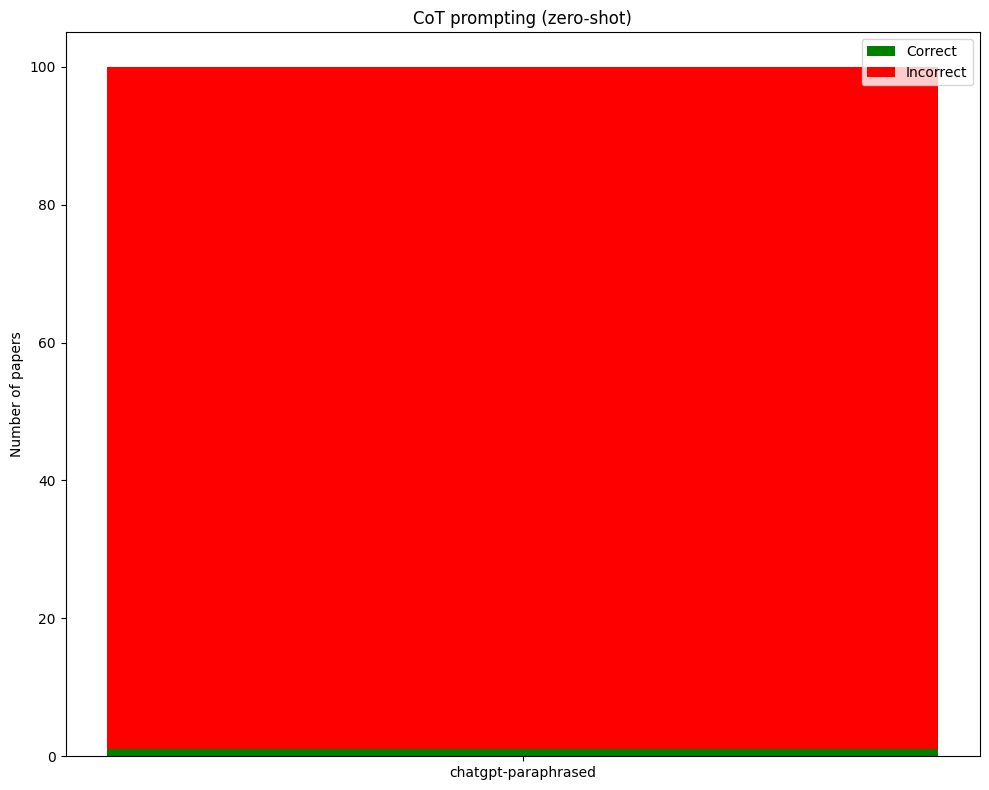

In [ ]:
# Create a list of prompting styles
prompting_styles = df["prompting_style"].unique()

# Create a list of paper sources
paper_srcs = df["paper_src"].unique()

# Create a subplot for each prompting style
fig, axs = plt.subplots(len(prompting_styles), 1, figsize=(10, 8))

# Ensure that axs is always a list
if len(prompting_styles) == 1:
    axs = [axs]

for i, prompting_style in enumerate(prompting_styles):
    # Get a subset of the dataframe for this prompting style
    df_subset = df[df["prompting_style"] == prompting_style]

    # Get the counts of correct and incorrect for each paper source
    correct_counts = df_subset[df_subset["correct"] == True]["paper_src"].value_counts()
    incorrect_counts = df_subset[df_subset["correct"] == False]["paper_src"].value_counts()

    # Create an array for each paper source with the correct and incorrect counts
    counts = [np.array([correct_counts.get(src, 0), incorrect_counts.get(src, 0)]) for src in paper_srcs]

    # Create the bar chart
    axs[i].bar(paper_srcs, [count[0] for count in counts], color='g', label='Correct')
    axs[i].bar(paper_srcs, [count[1] for count in counts], bottom=[count[0] for count in counts], color='r', label='Incorrect')

    axs[i].set_ylabel('Number of papers')
    axs[i].set_title(prompting_style)
    axs[i].legend()

# Show the plot
plt.tight_layout()
plt.show()